<a href="https://colab.research.google.com/github/NINGTANG1124/UPF-HFI/blob/main/notebooks/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connect to googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 合并 HFI 到建模数据表

In [88]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 读取survey
survey_df = pd.read_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/survey_with_HFI.xlsx")
df = pd.read_excel(survey_path)

# 读取upf
upf_path = "/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_percent.xlsx"
df_upf = pd.read_excel(upf_path)

In [91]:
# 1) 标准化列名（去前后空格）
survey_df.columns = survey_df.columns.str.strip()
df_upf.columns    = df_upf.columns.str.strip()

# 2) 识别并统一 upf 百分比列名 → upf_percent
upf_cands = ["upf_percent","weighted_upf_percent","fed_upf_percent","UPF_percent"]
found = [c for c in upf_cands if c in df_upf.columns]
assert len(found)>0, f"在 upf 表里找不到列：{upf_cands}"
if found[0] != "upf_percent":
    df_upf = df_upf.rename(columns={found[0]:"upf_percent"})

# 3) 找主键（优先用 UserID_clean） 未来你变量名改动了，代码还能自动适配，不用手动改两处
id_cands = [c for c in survey_df.columns if c.lower() in ("userid_clean","user_id_clean","userid","user_id","useid")]
assert len(id_cands)>0, "在 survey 里找不到用户ID列（如 UserID_clean/useid 等）"
IDCOL = id_cands[0]
# 如果 upf 表的 ID 列名和 survey 不同，这里也做个映射
if IDCOL not in df_upf.columns:
    upf_id_cands = [c for c in df_upf.columns if c.lower() in ("userid_clean","user_id_clean","userid","user_id","useid")]
    assert len(upf_id_cands)>0, "在 upf 表里找不到用户ID列"
    df_upf = df_upf.rename(columns={upf_id_cands[0]: IDCOL})

print("ID 使用列：", IDCOL)
print("UPF 列： upf_percent")


ID 使用列： UserID_clean
UPF 列： upf_percent


In [92]:
# 4) 合并（survey 为主）
df_model = survey_df.merge(df_upf[[IDCOL,"upf_percent"]], on=IDCOL, how="left")

# 5) 选择分析变量
Y_COL   = "upf_percent"
X_CORE  = "HFI_raw_score"     # 如需二分类就改成 "HFI_binary"
CONTROL = ["income","gender_participant","ethn_participant"]

need = [IDCOL, Y_COL, X_CORE] + CONTROL
missing = [c for c in need if c not in df_model.columns]
assert not missing, f"缺这些列：{missing}"

df_model = df_model[need].copy()

# 6) 快速检查
print("合并后形状：", df_model.shape)
print("缺失率：\n", df_model.isna().mean().round(3))
print("\nY/X描述性：\n", df_model[[Y_COL, X_CORE]].describe())

合并后形状： (326, 6)
缺失率：
 UserID_clean          0.000
upf_percent           0.000
HFI_raw_score         0.055
income                0.009
gender_participant    0.000
ethn_participant      0.000
dtype: float64

Y/X描述性：
        upf_percent  HFI_raw_score
count   326.000000     308.000000
mean     69.342111       1.415584
std      12.004849       2.069481
min      28.431105       0.000000
25%      62.256306       0.000000
50%      70.070425       0.000000
75%      77.755859       2.000000
max      96.730155       6.000000


## 1. VIF 多重共线性检查

In [93]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# 定义控制变量（确保名字和 df_model 列名一致）
control_vars = ["income", "gender_participant", "ethn_participant"]

# 检查变量是否都在 df_model 中
missing_vars = [var for var in control_vars if var not in df_model.columns]
print("缺失的变量:", missing_vars)


缺失的变量: []


In [94]:
# 如果有缺失变量，可以先停下来调整；如果没有缺失，继续
if not missing_vars:
    # 取出数据并去掉缺失
    vif_data = df_model[control_vars].dropna()

    # 如果有分类变量，转成哑变量
    vif_data = pd.get_dummies(vif_data, drop_first=True)

    # 计算 VIF
    vif_df = pd.DataFrame()
    vif_df["Variable"] = vif_data.columns
    vif_df["VIF"] = [variance_inflation_factor(vif_data.values, i)
                     for i in range(vif_data.shape[1])]

    print(vif_df)

             Variable       VIF
0              income  4.064203
1  gender_participant  4.375856
2    ethn_participant  2.258197


VIF 都在 10 以下（甚至都小于 5），说明 控制变量之间没有严重多重共线性，可以放心进入下一步逐轮建模了。

## 2. 建模：四轮模型：统一跑 OLS & HC3


In [95]:
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

Y_COL  = "upf_percent"
X_CORE = "HFI_raw_score"
CONTROLS = ["income", "gender_participant", "ethn_participant"]

# 1) 取干净样本
dm = df_model.dropna(subset=[Y_COL, X_CORE] + CONTROLS).copy()

# 2) 明确把这些列当“分类”
for c in ["gender_participant", "ethn_participant"]:
    dm[c] = dm[c].astype("category")

# 3) 选择“基准组”（用样本中最常见的那个类别做 reference，比固定选 1 更稳）
ref_gender = dm["gender_participant"].mode()[0]
ref_ethn   = dm["ethn_participant"].mode()[0]
print("基准组：gender =", ref_gender, " | ethnicity =", ref_ethn)

# 4) 四个模型（普通 OLS + HC3）
f1 = f"{Y_COL} ~ {X_CORE}"
f2 = f"{Y_COL} ~ {X_CORE} + income"
f3 = f"""{Y_COL} ~ {X_CORE} + income
          + C(gender_participant, Treatment(reference={ref_gender}))
          + C(ethn_participant,   Treatment(reference={ref_ethn}))"""
# 目前 M4 和 M3 一样；以后要加教育/家庭规模，直接在 f4 里 + 变量即可
f4 = f3

m1_ols = smf.ols(f1, data=dm).fit()
m2_ols = smf.ols(f2, data=dm).fit()
m3_ols = smf.ols(f3, data=dm).fit()
m4_ols = smf.ols(f4, data=dm).fit()

m1_hc3 = m1_ols.get_robustcov_results(cov_type="HC3")
m2_hc3 = m2_ols.get_robustcov_results(cov_type="HC3")
m3_hc3 = m3_ols.get_robustcov_results(cov_type="HC3")
m4_hc3 = m4_ols.get_robustcov_results(cov_type="HC3")


基准组：gender = 1  | ethnicity = 1


In [96]:
# 5) 输出“普通 OLS vs HC3”的并排对照表（论文好用）
ols_table = summary_col(
    results=[m1_ols, m2_ols, m3_ols, m4_ols],
    model_names=["M1 OLS","M2 OLS","M3 OLS","M4 OLS"],
    stars=True,
    info_dict={"N": lambda x: f"{int(x.nobs)}", "R²": lambda x: f"{x.rsquared:.4f}"}
)
print(ols_table)

hc3_table = summary_col(
    results=[m1_hc3, m2_hc3, m3_hc3, m4_hc3],
    model_names=["M1 HC3","M2 HC3","M3 HC3","M4 HC3"],
    stars=True,
    info_dict={"N": lambda x: f"{int(x.nobs)}", "R²": lambda x: f"{x.rsquared:.4f}"}
)
print(hc3_table)



                                                     M1 OLS     M2 OLS     M3 OLS     M4 OLS  
----------------------------------------------------------------------------------------------
Intercept                                          68.3022*** 66.4553*** 68.6060*** 68.6060***
                                                   (0.8379)   (2.1904)   (2.5259)   (2.5259)  
HFI_raw_score                                      0.7546**   0.9078**   1.0081***  1.0081*** 
                                                   (0.3361)   (0.3758)   (0.3776)   (0.3776)  
income                                                        0.4435     0.3982     0.3982    
                                                              (0.4859)   (0.4928)   (0.4928)  
C(gender_participant, Treatment(reference=1))[T.2]                       0.8478     0.8478    
                                                                         (1.3735)   (1.3735)  
C(ethn_participant, Treatment(reference=1))[T.2] 

In [97]:
import numpy as np

HFI_COL = "HFI_raw_score"
Y_COL   = "upf_percent"

def explain_models(models, model_type):
    for i, m in enumerate(models, 1):
        # 1) 找到 HFI 参数在设计矩阵中的位置
        names = list(m.model.exog_names)         # e.g. ['Intercept','HFI_raw_score', ...]
        j = names.index(HFI_COL)                 # HFI 的列号

        # 2) 取系数、p 值（兼容 Series/ndarray）
        slope = float(m.params[j])
        pvals = m.pvalues
        pval  = float(pvals[j] if np.ndim(pvals) else pvals)  # 兼容性写法

        # 3) 取置信区间（HC3 可能返回 ndarray；OLS 常是 DataFrame）
        ci = m.conf_int()
        if hasattr(ci, "iloc"):                  # DataFrame 情况
            ci_low, ci_high = float(ci.iloc[j, 0]), float(ci.iloc[j, 1])
        else:                                    # ndarray 情况
            ci_low, ci_high = float(ci[j, 0]), float(ci[j, 1])

        # 4) 输出一句话解释
        print(f"\n{model_type} Model {i}:")
        print(f"HFI 每增加 1 分，UPF 平均变化 {slope:.2f} 个百分点 "
              f"(95% CI [{ci_low:.2f}, {ci_high:.2f}], p={pval:.4f})")

print("=== OLS ===")
explain_models([m1_ols, m2_ols, m3_ols, m4_ols], "OLS")

print("\n=== HC3 ===")
explain_models([m1_hc3, m2_hc3, m3_hc3, m4_hc3], "HC3")


=== OLS ===

OLS Model 1:
HFI 每增加 1 分，UPF 平均变化 0.75 个百分点 (95% CI [0.09, 1.42], p=0.0255)

OLS Model 2:
HFI 每增加 1 分，UPF 平均变化 0.91 个百分点 (95% CI [0.17, 1.65], p=0.0163)

OLS Model 3:
HFI 每增加 1 分，UPF 平均变化 1.01 个百分点 (95% CI [0.27, 1.75], p=0.0080)

OLS Model 4:
HFI 每增加 1 分，UPF 平均变化 1.01 个百分点 (95% CI [0.27, 1.75], p=0.0080)

=== HC3 ===

HC3 Model 1:
HFI 每增加 1 分，UPF 平均变化 0.75 个百分点 (95% CI [0.12, 1.39], p=0.0209)

HC3 Model 2:
HFI 每增加 1 分，UPF 平均变化 0.91 个百分点 (95% CI [0.20, 1.61], p=0.0117)

HC3 Model 3:
HFI 每增加 1 分，UPF 平均变化 1.01 个百分点 (95% CI [0.29, 1.73], p=0.0061)

HC3 Model 4:
HFI 每增加 1 分，UPF 平均变化 1.01 个百分点 (95% CI [0.29, 1.73], p=0.0061)


/tmp/ipython-input-2771131310.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = float(m.params[j])
/tmp/ipython-input-2771131310.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval  = float(pvals[j] if np.ndim(pvals) else pvals)  # 兼容性写法


# 3. 两个模型的HFI 系数变化图

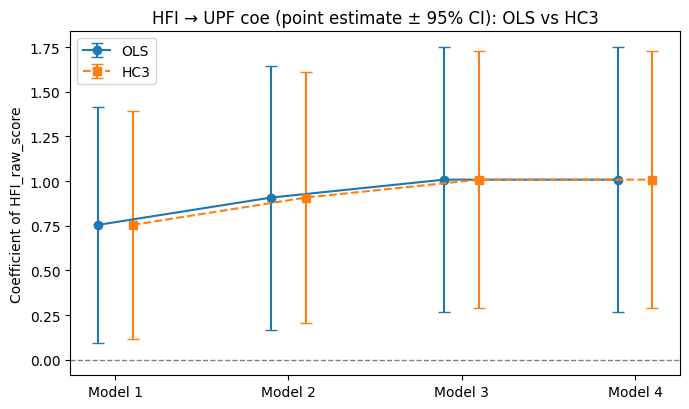

In [98]:
# =========================
# 图1：OLS vs HC3 同图对比
# =========================
x = np.arange(len(model_names))
plt.figure(figsize=(7,4.2))

# 稍微错位，避免遮挡
offset = 0.10
plt.errorbar(x-offset, ols_pack["coef"], yerr=ols_pack["yerr"], fmt='o-', capsize=4, label="OLS")
plt.errorbar(x+offset, hc3_pack["coef"], yerr=hc3_pack["yerr"], fmt='s--', capsize=4, label="HC3")

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(x, model_names)
plt.ylabel(f"Coefficient of {HFI_COL}")
plt.title("HFI → UPF coe (point estimate ± 95% CI): OLS vs HC3") # HFI → UPF 系数（点估计±95%CI）：OLS vs HC3
plt.legend()
plt.tight_layout()
plt.show()


图1：两个模型的 HFI 系数变化图（OLS vs HC3）

代码标题：HFI → UPF coe (point estimate ± 95% CI): OLS vs HC3

内容解释：
横轴是不同的模型版本（Model 1 到 Model 4），纵轴是 HFI_raw_score 对 UPF 的系数估计值。

蓝色圆点和线代表 OLS 估计值及其 95% 置信区间。

橙色方块和线代表 HC3（稳健标准误）估计值及其 95% 置信区间。

说明了什么：用 OLS 和 HC3 得到的系数数值基本一致，但置信区间长度有差异（HC3 略宽），提示稳健标准误在某些模型下考虑了异方差的可能性。

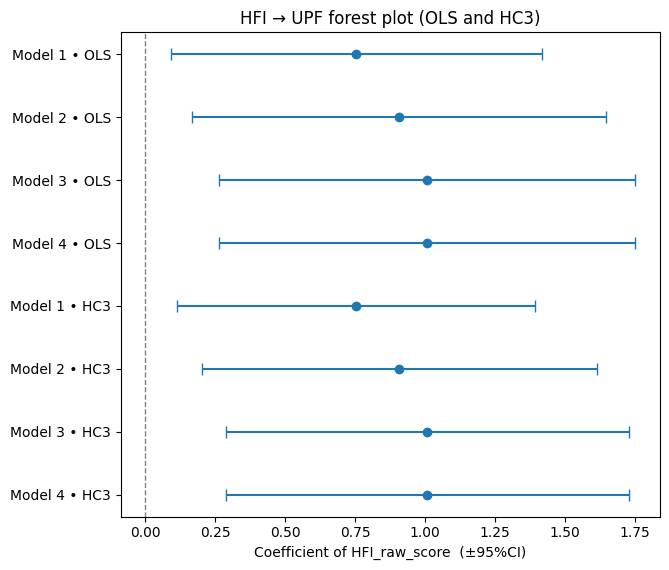

In [99]:
# =========================
# 图2：森林图（8 个模型排一列）
# =========================
# 合并为一个长表顺序：OLS1..4, HC31..4
all_labels = [f"{n} • OLS" for n in model_names] + [f"{n} • HC3" for n in model_names]
all_coef   = np.r_[ols_pack["coef"], hc3_pack["coef"]]
all_yerr   = np.concatenate([ols_pack["yerr"], hc3_pack["yerr"]], axis=1)  # shape (2, 8)

y = np.arange(len(all_labels))[::-1]  # 反向让第一行在最上
plt.figure(figsize=(6.8,5.8))
plt.errorbar(all_coef, y, xerr=all_yerr, fmt='o', capsize=4)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.yticks(y, all_labels)
plt.xlabel(f"Coefficient of {HFI_COL}  (±95%CI)")
plt.title("HFI → UPF forest plot (OLS and HC3)") # HFI → UPF 森林图（OLS 与 HC3）
plt.tight_layout()
plt.show()

图2：森林图（8 个模型系数一列排）

代码标题：HFI → UPF forest plot (OLS and HC3)

内容解释：

每行是一个模型系数及 95% CI，按照 OLS 和 HC3 各四个模型排列。

横轴是系数大小，竖轴列出了 Model n • OLS 和 Model n • HC3。

说明了什么：便于直接比较不同模型、不同标准误处理方法下的系数及置信区间差异。视觉上更适合对比具体数值差距。

# 4. 最终模型（M4）细化

## 4.1 M4（OLS & HC3）详细系数表（含性别/族裔哑变量）

In [109]:
# 变量标签准备
ethn_labels = {
    1: "White British",  # 基准
    2: "Other white group",
    3: "Pakistani",
    4: "Indian",
    5: "Bangladeshi",
    6: "Other Asian group",
    7: "Mixed/multiple ethnicity",
    8: "Black / Black British / Black Caribbean / Black African",
    9: "Other ethnic group"
}

In [110]:
# 目标种族变量（基准 White British 不画）
ethn_keys = list(range(2, 10))
ethn_names = [ethn_labels[k] for k in ethn_keys]

# 提取 M4 OLS & HC3 对应种族的系数和 CI
def get_ethn_coef_ci(model, prefix="C(ethn_participant, Treatment(reference=1))[T."):
    coefs, lows, highs = [], [], []
    for k in ethn_keys:
        term = f"{prefix}{k}]"
        idx = list(model.params.index).index(term)
        coefs.append(model.params[idx])
        lows.append(model.conf_int().iloc[idx, 0])
        highs.append(model.conf_int().iloc[idx, 1])
    return np.array(coefs), np.array(lows), np.array(highs)

coef_ols, low_ols, high_ols = get_ethn_coef_ci(m4_ols)
coef_hc3, low_hc3, high_hc3 = get_ethn_coef_ci(m4_hc3)

# 绘图
y_pos = np.arange(len(ethn_names))
plt.figure(figsize=(7,6))
plt.errorbar(coef_ols, y_pos+0.1, xerr=[coef_ols-low_ols, high_ols-coef_ols],
             fmt='o', capsize=4, label='M4 OLS')
plt.errorbar(coef_hc3, y_pos-0.1, xerr=[coef_hc3-low_hc3, high_hc3-coef_hc3],
             fmt='s', capsize=4, label='M4 HC3')

plt.axvline(0, color='gray', linestyle='--')
plt.yticks(y_pos, ethn_names)
plt.xlabel("Coefficient (95% CI)")
plt.title("Ethnicity vs White British (M4 OLS & HC3)")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-2331166816.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefs.append(model.params[idx])


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [101]:
# 生成模型参数顺序
param_order = []
# 性别
for k in gender_labels:
    if k != 1:  # 1是基准组
        param_order.append(term_gender(k))
# 种族
for k in ethn_labels:
    if k != 1:
        param_order.append(term_ethn(k))
# 其他变量
param_order += ["HFI_raw_score", "income"]


# 解包？？？？

In [105]:
ret = coef_and_ci(m4_ols, param_order)
print(len(ret), [type(x) for x in ret])


5 [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'list'>, <class 'list'>]


/tmp/ipython-input-2116566312.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c = model.params[idx]


也就是 coef_and_ci(...) 返回 5 个值，依次是：
系数（ndarray）
CI 下界（ndarray）
CI 上界（ndarray）
已找到的参数名（list）
缺失的参数名（list）

In [106]:
# 取模型系数 + 置信区间
coef_ols, lo_ols, hi_ols, found_ols, miss_ols = coef_and_ci(m4_ols, param_order)
coef_hc3, lo_hc3, hi_hc3, found_hc3, miss_hc3 = coef_and_ci(m4_hc3, param_order)


/tmp/ipython-input-2116566312.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c = model.params[idx]


TypeError: bad operand type for unary -: 'ellipsis'

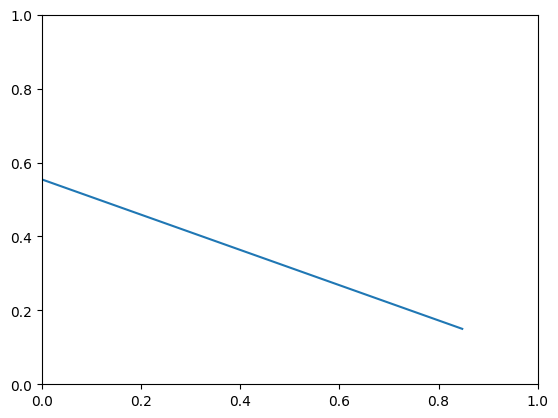

In [108]:
# 对齐 OLS 和 HC3 的变量
ok_both = [p for p in ok_ols if p in ok_hc3]

# 画森林图
plt.errorbar(coef_ols, y_pos+0.15, xerr=..., label="M4 OLS")
plt.errorbar(coef_hc3, y_pos-0.15, xerr=..., label="M4 HC3")


/tmp/ipython-input-2116566312.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c = model.params[idx]


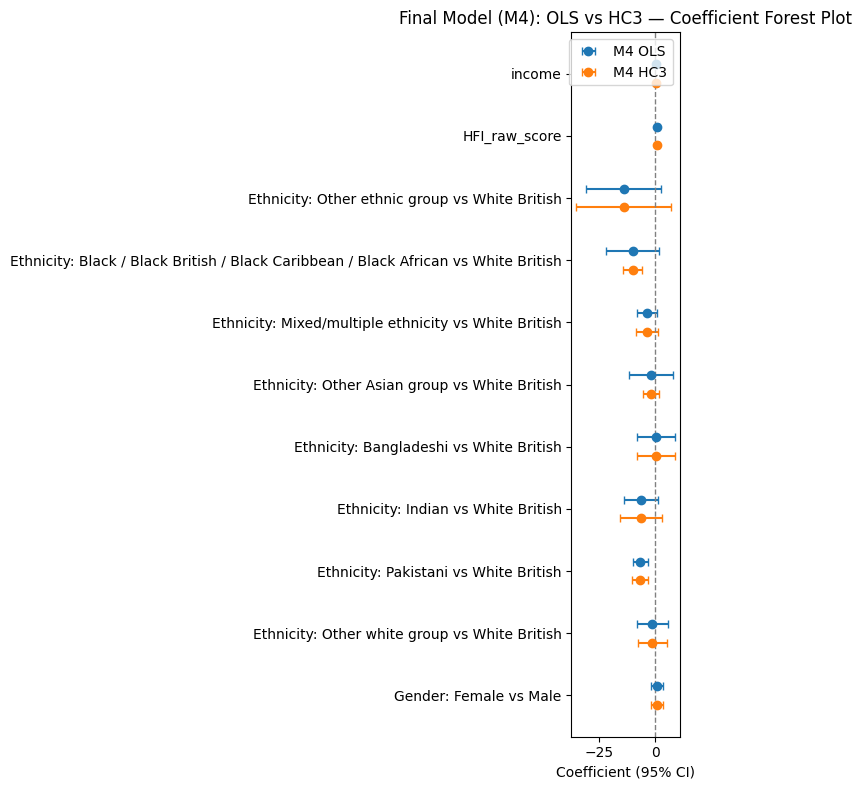

In [87]:
# === 配置：把问卷真实标签放进来 ===
gender_labels = {
    1: "Male",       # 基准
    2: "Female"
}

ethn_labels = {
    1: "White British",  # 基准
    2: "Other white group",
    3: "Pakistani",
    4: "Indian",
    5: "Bangladeshi",
    6: "Other Asian group",
    7: "Mixed/multiple ethnicity",
    8: "Black / Black British / Black Caribbean / Black African",
    9: "Other ethnic group"
}

# === 助手：构造模型里的参数名（与 Patsy 产生的一致）===
def term_gender(k):
    # C(gender_participant, Treatment(reference=1))[T.k]
    return f"C(gender_participant, Treatment(reference=1))[T.{k}]"

def term_ethn(k):
    # C(ethn_participant, Treatment(reference=1))[T.k]
    return f"C(ethn_participant, Treatment(reference=1))[T.{k}]"

# 期望画出来的参数顺序（从分类开始到连续变量）
param_order = []

# 性别：仅画非基准（2,3），对比基准 1=Male
for k in sorted(gender_labels):
    if k != 1:
        param_order.append(term_gender(k))

# 种族：仅画非基准（2..9），对比基准 1=White British
for k in sorted(ethn_labels):
    if k != 1:
        param_order.append(term_ethn(k))

# 最后加上连续变量（你最终模型里有它们）
param_order += ["HFI_raw_score", "income"]

# 生成 y 轴友好标签（和 param_order 一一对应）
y_labels = []
for p in param_order:
    if p.startswith("C(gender_participant"):
        k = int(p.split("T.")[1].split("]")[0])
        y_labels.append(f"Gender: {gender_labels[k]} vs {gender_labels[1]}")
    elif p.startswith("C(ethn_participant"):
        k = int(p.split("T.")[1].split("]")[0])
        y_labels.append(f"Ethnicity: {ethn_labels[k]} vs {ethn_labels[1]}")
    elif p == "HFI_raw_score":
        y_labels.append("HFI_raw_score")
    elif p == "income":
        y_labels.append("income")
    else:
        y_labels.append(p)

# === 从模型里安全提取系数与CI（若缺失则跳过并提示）===
import numpy as np
def coef_and_ci(model, params, alpha=0.05):
    """对给定 params（参数名字符串列表）返回：
       (coef数组, lo数组, hi数组, 实际存在的参数名列表, 缺失的参数名列表)
       兼容：model.params 可能是 numpy 数组；conf_int 可能是 DataFrame 或 ndarray
    """
    import numpy as np

    found_coef, lo, hi, found_names, missing = [], [], [], [], []

    # 所有参数名（按模型内部顺序）
    all_names = list(getattr(model.model, "exog_names", []))
    # 置信区间（可能是 DataFrame，也可能是 ndarray）
    ci = model.conf_int(alpha=alpha)

    for p in params:
        if p in all_names:
            idx = all_names.index(p)   # 用索引定位
            # 系数
            if hasattr(model.params, "__getitem__"):
                c = model.params[idx]
            else:
                # 极少数情况下保险
                c = np.asarray(model.params)[idx]

            # 置信区间下/上界
            if hasattr(ci, "iloc"):     # pandas DataFrame
                l = ci.iloc[idx, 0]
                h = ci.iloc[idx, 1]
            else:                       # numpy ndarray
                l = ci[idx, 0]
                h = ci[idx, 1]

            found_names.append(p)
            found_coef.append(c); lo.append(l); hi.append(h)
        else:
            missing.append(p)

    return np.array(found_coef), np.array(lo), np.array(hi), found_names, missing

# 提取 OLS 与 HC3
coef_ols, lo_ols, hi_ols, ok_ols, miss_ols = coef_and_ci(m4_ols, param_order)
coef_hc3, lo_hc3, hi_hc3, ok_hc3, miss_hc3 = coef_and_ci(m4_hc3, param_order)

# 对齐两组（只画两边都同时存在的）
ok_both = [p for p in ok_ols if p in ok_hc3]
def take_in_order(names, target, arr):
    idx = [names.index(t) for t in target]
    return arr[idx]

coef_ols = take_in_order(ok_ols, ok_both, coef_ols)
lo_ols   = take_in_order(ok_ols, ok_both, lo_ols)
hi_ols   = take_in_order(ok_ols, ok_both, hi_ols)

coef_hc3 = take_in_order(ok_hc3, ok_both, coef_hc3)
lo_hc3   = take_in_order(ok_hc3, ok_both, lo_hc3)
hi_hc3   = take_in_order(ok_hc3, ok_both, hi_hc3)

# 同步 y 轴标签
label_map = dict(zip(param_order, y_labels))
y_final = [label_map[p] for p in ok_both]

# === 画森林图：OLS vs HC3 对比 ===
import matplotlib.pyplot as plt

y_pos = np.arange(len(ok_both))
plt.figure(figsize=(7, 8))

# OLS
plt.errorbar(
    coef_ols, y_pos + 0.15,
    xerr=[coef_ols - lo_ols, hi_ols - coef_ols],
    fmt='o', capsize=3, label="M4 OLS"
)

# HC3
plt.errorbar(
    coef_hc3, y_pos - 0.15,
    xerr=[coef_hc3 - lo_hc3, hi_hc3 - coef_hc3],
    fmt='o', capsize=3, label="M4 HC3"
)

plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
plt.yticks(y_pos, y_final)
plt.xlabel("Coefficient (95% CI)")
plt.title("Final Model (M4): OLS vs HC3 — Coefficient Forest Plot")
plt.legend()
plt.tight_layout()
plt.show()

# 可选：提示一下有哪些参数在某个模型里没找到（通常是因为被模型自动丢弃或没进入）
if miss_ols or miss_hc3:
    print("下列参数在模型中未找到（未绘制）：")
    if miss_ols:
        print("  - 仅 OLS 缺失：", miss_ols)
    if miss_hc3:
        print("  - 仅 HC3 缺失：", miss_hc3)


## 5.2 M4：OLS vs HC3 系数森林图（已按你设定的参考组）

In [66]:
import numpy as np
import matplotlib.pyplot as plt

HFI_COL = "HFI_raw_score"
model_names = ["Model 1", "Model 2", "Model 3", "Model 4"]

# ---- 小工具：从模型对象中提取系数和95%CI（兼容 OLS/HC3） ----
def coef_ci(model, param):
    names = list(model.model.exog_names)
    j = names.index(param)
    b  = float(model.params[j])
    ci = model.conf_int()
    if hasattr(ci, "iloc"):   # DataFrame
        lo, hi = float(ci.iloc[j,0]), float(ci.iloc[j,1])
    else:                     # ndarray
        lo, hi = float(ci[j,0]), float(ci[j,1])
    return b, lo, hi

def pack(models, label):
    coefs, lows, highs = [], [], []
    for m in models:
        b, lo, hi = coef_ci(m, HFI_COL)
        coefs.append(b); lows.append(lo); highs.append(hi)
    coefs = np.array(coefs); lows = np.array(lows); highs = np.array(highs)
    yerr = np.vstack([coefs - lows, highs - coefs])  # 非对称误差条
    return {"label": label, "coef":coefs, "yerr":yerr}

# ---- 组装数据 ----
ols_pack = pack([m1_ols, m2_ols, m3_ols, m4_ols], "OLS")
hc3_pack = pack([m1_hc3, m2_hc3, m3_hc3, m4_hc3], "HC3")


/tmp/ipython-input-388825580.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b  = float(model.params[j])


# 画 M4 OLS + M4 HC3 的森林图

In [73]:
print("M4 OLS exog names:\n", getattr(m4_ols.model, "exog_names", None))
print("M4 HC3 exog names:\n", getattr(m4_hc3.model, "exog_names", None))


M4 OLS exog names:
 ['Intercept', 'C(gender_participant, Treatment(reference=1))[T.2]', 'C(ethn_participant, Treatment(reference=1))[T.2]', 'C(ethn_participant, Treatment(reference=1))[T.3]', 'C(ethn_participant, Treatment(reference=1))[T.4]', 'C(ethn_participant, Treatment(reference=1))[T.5]', 'C(ethn_participant, Treatment(reference=1))[T.6]', 'C(ethn_participant, Treatment(reference=1))[T.7]', 'C(ethn_participant, Treatment(reference=1))[T.8]', 'C(ethn_participant, Treatment(reference=1))[T.9]', 'HFI_raw_score', 'income']
M4 HC3 exog names:
 ['Intercept', 'C(gender_participant, Treatment(reference=1))[T.2]', 'C(ethn_participant, Treatment(reference=1))[T.2]', 'C(ethn_participant, Treatment(reference=1))[T.3]', 'C(ethn_participant, Treatment(reference=1))[T.4]', 'C(ethn_participant, Treatment(reference=1))[T.5]', 'C(ethn_participant, Treatment(reference=1))[T.6]', 'C(ethn_participant, Treatment(reference=1))[T.7]', 'C(ethn_participant, Treatment(reference=1))[T.8]', 'C(ethn_participa

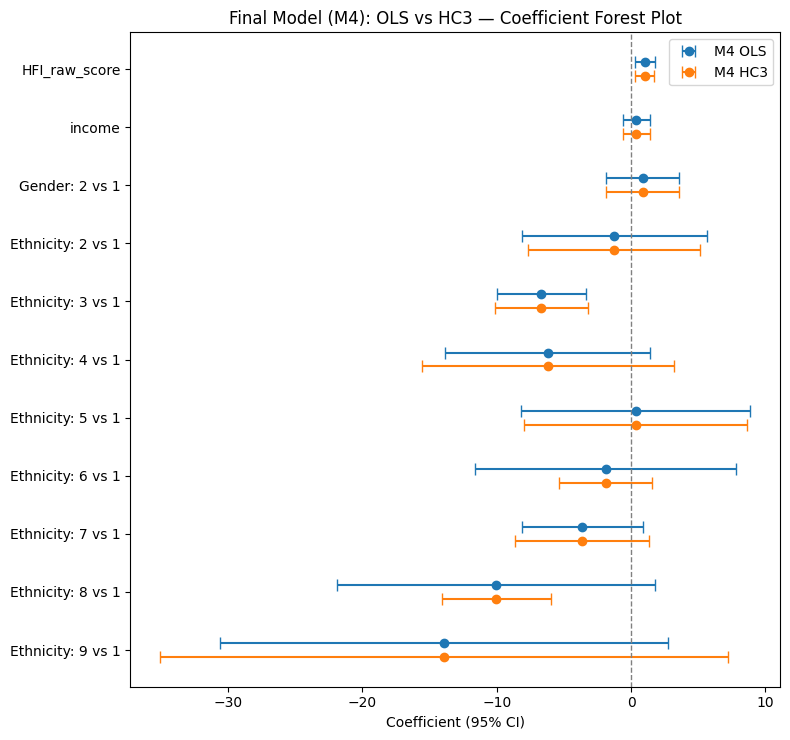

用于作图的参数项：
 - HFI_raw_score
 - income
 - C(gender_participant, Treatment(reference=1))[T.2]
 - C(ethn_participant, Treatment(reference=1))[T.2]
 - C(ethn_participant, Treatment(reference=1))[T.3]
 - C(ethn_participant, Treatment(reference=1))[T.4]
 - C(ethn_participant, Treatment(reference=1))[T.5]
 - C(ethn_participant, Treatment(reference=1))[T.6]
 - C(ethn_participant, Treatment(reference=1))[T.7]
 - C(ethn_participant, Treatment(reference=1))[T.8]
 - C(ethn_participant, Treatment(reference=1))[T.9]


In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

models = [m4_ols, m4_hc3]
model_labels = ["M4 OLS", "M4 HC3"]

# 1) 从 OLS 模型拿“真实参数名”
names = list(getattr(m4_ols.model, "exog_names"))
# 想要的顺序：先连续，再性别，再种族（你可以改顺序）
keep = []

# 连续项
for nm in ["HFI_raw_score", "income"]:
    if nm in names:
        keep.append(nm)

# 性别所有对比项（不含 Intercept）
gender_terms = [n for n in names if n.startswith("C(gender_participant,")]
keep += gender_terms

# 种族所有对比项
ethn_terms = [n for n in names if n.startswith("C(ethn_participant,")]
keep += ethn_terms

# 如果一个都没匹配到，提示一下
if not keep:
    raise ValueError(f"没有匹配到要画的参数。可选参数有：\n{names}")

def coef_and_ci(model, term_names):
    """按指定名字顺序取系数与95%CI（兼容 pandas/ndarray）"""
    # 系数
    if isinstance(model.params, pd.Series):
        coef = model.params.loc[term_names].values
        ci   = model.conf_int().loc[term_names].values
    else:
        # 退路（一般用不到）
        all_names = list(getattr(model.model, "exog_names"))
        idx = [all_names.index(t) for t in term_names]
        coef = np.asarray(model.params, float)[idx]
        ci   = np.asarray(model.conf_int(), float)[idx, :]
    lo, hi = ci[:,0], ci[:,1]
    return coef, lo, hi

# 2) 收集 OLS & HC3 的系数与区间
coef_list, lo_list, hi_list = [], [], []
for m in models:
    c, lo, hi = coef_and_ci(m, keep)
    coef_list.append(c); lo_list.append(lo); hi_list.append(hi)

# 3) 生成更易读的标签
pretty = []
for n in keep:
    if n == "HFI_raw_score":
        pretty.append("HFI_raw_score")
    elif n == "income":
        pretty.append("income")
    elif n.startswith("C(gender_participant"):
        # 例：C(gender_participant, Treatment(reference=1))[T.2]
        lvl = n.split("T.")[-1].rstrip("]")
        pretty.append(f"Gender: {lvl} vs 1")
    elif n.startswith("C(ethn_participant"):
        lvl = n.split("T.")[-1].rstrip("]")
        pretty.append(f"Ethnicity: {lvl} vs 1")
    else:
        pretty.append(n)

# 4) 画森林图
y = np.arange(len(keep))[::-1]
fig, ax = plt.subplots(figsize=(8, 0.5*len(keep) + 2))
colors = ['tab:blue', 'tab:orange']
offset = 0.12

for i, (coef, lo, hi) in enumerate(zip(coef_list, lo_list, hi_list)):
    xerr = np.vstack([coef - lo, hi - coef])
    ax.errorbar(coef, y + (offset if i==0 else -offset),
                xerr=xerr, fmt='o', capsize=4, color=colors[i],
                label=model_labels[i])

ax.axvline(0, color='grey', linestyle='--', linewidth=1)
ax.set_yticks(y)
ax.set_yticklabels(pretty)
ax.set_xlabel("Coefficient (95% CI)")
ax.set_title("Final Model (M4): OLS vs HC3 — Coefficient Forest Plot")
ax.legend()
plt.tight_layout()
plt.show()

print("用于作图的参数项：")
for n in keep: print(" -", n)


## 5.3 M4 诊断图（残差-拟合，Q-Q，Cook’s D + Top 影响点）
残差 vs 拟合值

正态 Q–Q

Cook’s D（并打印影响力最大的前 10 个 ID）

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

resid  = m4.resid
fitted = m4.fittedvalues

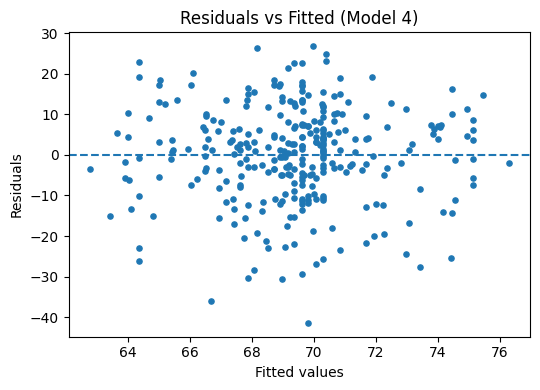

In [55]:
# 1) 残差 vs 拟合值
plt.figure(figsize=(5.5,4))
plt.scatter(fitted, resid, s=14)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Model 4)")
plt.tight_layout()
plt.show()          # ← 在notebook里显示


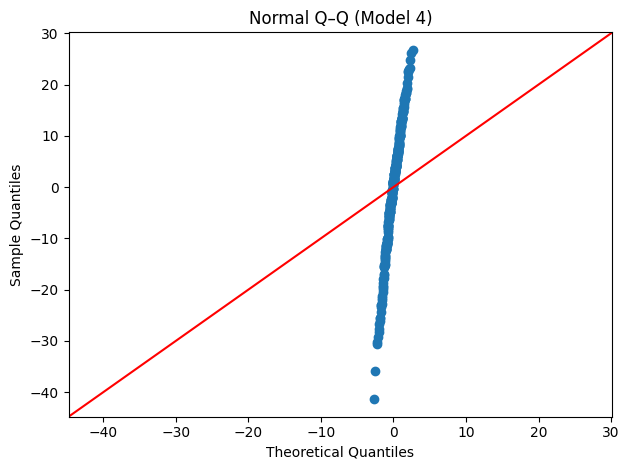

In [56]:
# 2) 正态 Q–Q
sm.ProbPlot(resid).qqplot(line="45")
plt.title("Normal Q–Q (Model 4)")
plt.tight_layout()
plt.show()

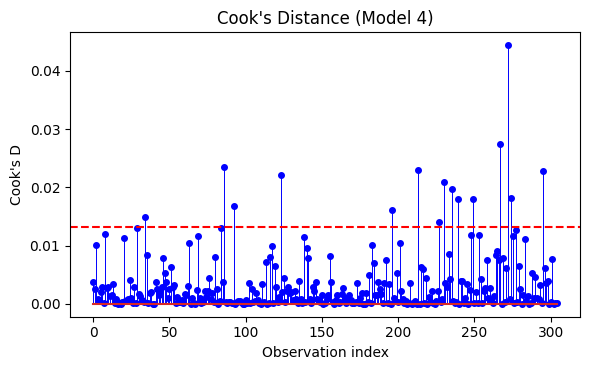

In [57]:
# 3) Cook's D（含阈值线）
influence = m4.get_influence()
cooks = influence.cooks_distance[0]
thr = 4 / len(m4_df)

plt.figure(figsize=(6, 3.8))
markerline, stemlines, baseline = plt.stem(np.arange(len(cooks)), cooks)
plt.setp(markerline, marker='o', markersize=4, color='blue')
plt.setp(stemlines, color='blue', linewidth=0.7)
plt.axhline(thr, linestyle="--", color='red')
plt.xlabel("Observation index")
plt.ylabel("Cook's D")
plt.title("Cook's Distance (Model 4)")
plt.tight_layout()
plt.show()

In [58]:
thr = 4/len(m4_df)
mask = m4.get_influence().cooks_distance[0] <= thr
m4_trim = sm.OLS(m4_df.loc[mask, Y_COL], sm.add_constant(m4_df.loc[mask, CONTROL_4], has_constant="add")).fit(cov_type="HC3")
print("原始 HFI β:", m4.params["HFI_raw_score"], "  剔除后 HFI β:", m4_trim.params["HFI_raw_score"])
print("原始 p:", m4.pvalues["HFI_raw_score"], "  剔除后 p:", m4_trim.pvalues["HFI_raw_score"])


原始 HFI β: 1.03698718913994   剔除后 HFI β: 0.9726488120245399
原始 p: 0.0038362505266205365   剔除后 p: 0.0014355111158998314


In [59]:
# 可选：看看影响力最大的前10个观测
ids = df_model.loc[m4_df.index, "UserID_clean"] if "UserID_clean" in df_model.columns else m4_df.index
top_idx = np.argsort(cooks)[-10:][::-1]
top_table = pd.DataFrame({
    "UserID": ids.iloc[top_idx].values,
    "CookD": cooks[top_idx].round(4),
    "HFI_raw_score": m4_df["HFI_raw_score"].iloc[top_idx].values,
    Y_COL: m4_df[Y_COL].iloc[top_idx].values
})
top_table

,UserID,CookD,HFI_raw_score,upf_percent
0,BFD382,0.0444,0.0,30.768893
1,BFD373,0.0275,5.0,94.370910
2,BFD119,0.0235,0.0,38.194109
3,BFD290,0.0229,5.0,45.776471
4,BFD412,0.0228,0.0,28.431105
5,BFD168,0.0221,4.0,48.954415
6,BFD310,0.0209,5.0,48.638376
7,BFD317,0.0198,0.0,38.392675
8,BFD384,0.0181,0.0,87.280734
9,BFD341,0.0181,0.0,41.426197
